# Generate initial and time-varying profile and surface forcing
### Developed by Tim Juliano (NCAR/RAL), Ann Fridlind (NASA-GISS), and Florian Tornow (NASA-GISS/Columbia Univ.)
### v2.0 created on 6/1/23
### We have the option of starting as far as 28 hours before arriving at Andenes (03/12/20 at 14 UTC)
### Includes lat/lon correction by Peng Wu (PNNL)
#### NOTE: NO O3 INFORMATION IN FILE RIGHT NOW, WILL ADD LATER
#### NOTE: ONLY NUDGING FOR NOW, AM NOT COMPUTING GEOSTROPHIC WIND PROFILES

### Import libraries

In [1]:
import netCDF4
import numpy as np
import numpy.ma as ma
import sys
from netCDF4 import Dataset, date2num,num2date
import datetime as dt
import os
import matplotlib.pyplot as plt
from scipy import interpolate
import geopy.distance
from scipy.ndimage import gaussian_filter1d
import gdal

### !!! User mods !!!
#### How many hours before ice edge do you want to start?
#### Note: t0_h = 0 means you are starting approx. at ice edge, t0_h = 10 means you are starting 10 h upstream (north) of the ice edge
#### Note: t0_h must be an integer

In [2]:
t0_h = 5
if t0_h < 0 or t0_h > 10:
    sys.exit('Error: Please set 0 <= t0_h >= 10')

### Set some things

In [3]:
nhrs = 18 + t0_h + 1 # total number of simulation hours, including t0; default is from 2020-03-12 at 14 UTC to 2020-03-14 at 00 UTC
if t0_h == 0:
    start_time = '2020-03-13 00:00:00'
    start_day = 13
    start_hour = 0
else:
    start_time = '2020-03-12 ' + str(24-t0_h) + ':00:00'
    start_day = 12
    start_hour = 24-t0_h
print ('Start time is: ' + start_time)

Start time is: 2020-03-12 19:00:00


### Forcing NetCDF name and delete file if already exists

In [4]:
savename = 'COMBLE_INTERCOMPARISON_FORCING_ERA5ML_V2.0.nc'

if os.path.exists(savename):
    os.remove(savename)
    print('The file ' + savename + ' has been deleted successfully')

The file COMBLE_INTERCOMPARISON_FORCING_ERA5ML_V2.0.nc has been deleted successfully


### Get LES domain locations

In [5]:
fname_les_domain = 'LES_domain_location_28h_18Z_Mar13_2020.txt'

les_loc = np.loadtxt(fname_les_domain,skiprows=1)
les_hh = les_loc[:,0]
les_hh_idx = np.where(les_hh>=-1.*t0_h)[0]
les_lat = les_loc[les_hh_idx,1]
les_lat2 = les_lat[::12]
les_lon = les_loc[les_hh_idx,2]
les_lon2 = les_lon[::12]

les_lat_mid = round(np.mean(les_lat),1)
les_lon_mid = round(np.mean(les_lon),1)
print ('LES domain mid point: ' + 'lat=' + str(les_lat_mid) + 'N, lon=' + str(les_lon_mid) + 'E')

LES domain mid point: lat=75.6N, lon=9.0E


### Create vertical grid
#### 160 vertical grid levels, defined at the cell faces

In [6]:
nz = 160

dz_grid = np.empty(nz-1)
dz_grid[0] = 20.0
dz_grid[1] = 25.0
dz_grid[2] = 30.0
dz_grid[3] = 35.0
dz_grid[4:140] = 40.0
dz_grid[140] = 60.0
dz_grid[141:157] = 80.0
dz_grid[157] = 60.0
dz_grid[158] = 50.0

z_grid = np.empty(nz)
z_grid[0] = 0.0
for i in np.arange(1,len(z_grid)):
    z_grid[i] = z_grid[i-1] + dz_grid[i-1]

### Read in data from ERA5 backtrajectory (netCDF)

In [7]:
# File name
fname_era5 = 'theta_temp_rh_sh_uvw_sst_along_trajectory_era5ml_28h_end_2020-03-13-18.nc'

# Open dataset
dataset = netCDF4.Dataset(fname_era5, "r")

# Read variables (1D arrays are time, 2D arrays are time x pressure level)
hours = dataset.variables['Time'][:]
lat = dataset.variables['Latitude'][:]
lon = dataset.variables['Longitude'][:]
pres = dataset.variables['Pressure'][:]
sfc_pres = dataset.variables['SfcPres'][:]
sst = dataset.variables['SST'][:]
hgt = dataset.variables['GEOS_HT'][:,:]
uwnd = dataset.variables['U'][:,:]
vwnd = dataset.variables['V'][:,:]
wwnd = dataset.variables['W'][:,:]
temp = dataset.variables['Temp'][:,:]
theta = dataset.variables['Theta'][:,:]
qv = dataset.variables['SH'][:,:]

# File name
fname_era5_o3 = 'ERA5_forcing_along_trajectory_end_2020-03-13-18.nc'

# Open dataset
dataset_o3 = netCDF4.Dataset(fname_era5_o3, "r")

o3 = dataset_o3.variables['O3'][:,:]
pres_o3 = dataset_o3.variables['Pressure'][:]

### Convert units

In [8]:
sfc_pres_pa = sfc_pres/100.  # Pa to hPa
pres_pa = pres*100.          # hPa to Pa
pres_o3_pa = pres_o3*100.    # hPa to Pa

### Reverse time dimension of 2D arrays, as well as sfc pressure and sst, so that beginning of backward trajectory is in first position

In [9]:
hgt = np.flip(hgt,axis=0)
uwnd = np.flip(uwnd,axis=0)
vwnd = np.flip(vwnd,axis=0)
wwnd = np.flip(wwnd,axis=0)
temp = np.flip(temp,axis=0)
theta = np.flip(theta,axis=0)
qv = np.flip(qv,axis=0)
o3 = np.flip(o3,axis=0)
sfc_pres_pa = sfc_pres_pa[::-1]
sst = sst[::-1]

### Unmask sst field and get index according to t0_h (furthest north we can go is 28h after backtrajectory initialization from Andenes, or 3/12/20 at 14 UTC)

In [10]:
sst_real = ma.getdata(sst)
loopidx = np.where(sst_real>0.0)[0]
t0 = loopidx[10-t0_h]

### Calculate sfc potential temperature

In [11]:
theta1000mb = theta[:,0]
sfc_theta = theta1000mb*pow((1000./sfc_pres_pa),0.286)

### Get information at t0

In [12]:
z1 = 0

pres_t0 = pres_pa[z1:]
pres_o3_t0 = pres_o3_pa[z1:]
hgt_t0 = hgt[t0,z1:]
uwnd_t0 = uwnd[t0,z1:]
vwnd_t0 = vwnd[t0,z1:]
wwnd_t0 = wwnd[t0,z1:]
temp_t0 = temp[t0,z1:]
theta_t0 = theta[t0,z1:]
qv_t0 = qv[t0,z1:]

# temporal avg for o3
o3_t0 = np.mean(o3[0:21,z1:],axis=0)

ps_t0 = sfc_pres_pa[t0]
thetas_t0 = sfc_theta[t0]

### Extrapolate O3 since ERA5 only goes to 1 hPa and plot versus original profile

<Figure size 432x288 with 0 Axes>

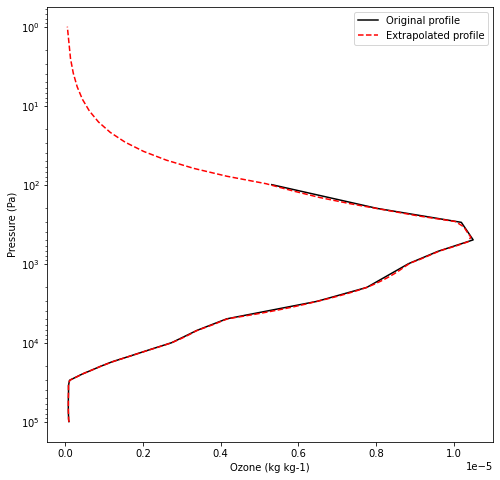

In [13]:
# Add top pressure and o3 value - here we assume o3 goes to zero at 1e-4 Pa
pres_o3_t0_add_top = np.insert(pres_o3_t0,len(pres_o3_t0),0.0001)
o3_t0_add_top = np.insert(o3_t0,len(o3_t0),0.0)

# Add bottom pressure and o3 value - here we assume o3 is constant near the sfc
pres_o3_t0_add_top_bottom = np.insert(pres_o3_t0_add_top,0,pres_t0[0])
o3_t0_add_top_bottom = np.insert(o3_t0_add_top,0,o3_t0[0])

# Do the extrapolation
f = interpolate.interp1d(pres_o3_t0_add_top_bottom, o3_t0_add_top_bottom, kind='linear',fill_value='extrapolate')
o3_t0i = f(pres_t0.data)

plt.figure()
plt.figure(figsize=(8,8))

var_plt1 = o3_t0
var_plt2 = o3_t0i
plt.plot(var_plt1,pres_o3_t0,c='k',label='Original profile')
plt.plot(var_plt2,pres_t0,c='r',ls='--',label='Extrapolated profile')
plt.legend()
plt.xlabel('Ozone (kg kg-1)')
plt.ylabel('Pressure (Pa)')
plt.yscale('log')
plt.gca().invert_yaxis()

plt.show()

### Get Geostrophic wind forcing

In [14]:
do_geo = True # TEMPORARY FLAG
if do_geo == True:
    # Read ERA5 file
    era5_geo_file = '/glade/scratch/tjuliano/doe_comble/wrf_asr_cao/WRF-ASR-CAO/scripts/era5/era5_mar13_case_larger.nc'
    dataset = netCDF4.Dataset(era5_geo_file, "r")

    zl = dataset.variables['z'][24-t0_h:43,0:-1,:,:] # time, lev, lat, lon
    lonarrl = dataset.variables['longitude'][:]
    latarrl = dataset.variables['latitude'][:]

    latloc = np.empty(len(les_lat2),dtype=np.int16)
    lonloc = np.empty(len(les_lat2),dtype=np.int16)
    ugl = np.empty([len(les_lat2),np.shape(zl)[1]])
    vgl = np.empty([len(les_lat2),np.shape(zl)[1]])
    zhtl = np.empty([len(les_lat2),np.shape(zl)[1]])

    omega = 7.2921e-5 # angular velocity
    g = 9.81 # grav constant
    min_dx = 20. # minimum grid spacing (km) for discretization
    min_dy = 20.
    for i in np.arange(len(les_lat2)):
        hold = np.abs(les_lat2[i]-latarrl)
        latloc[i] = np.argmin(hold)
        hold = np.abs(les_lon2[i]-lonarrl)   
        lonloc[i] = np.argmin(hold)

        # Coriolis parameter
        e = 2*omega*np.cos(np.radians(les_lat2[i]))
        f = 2*omega*np.sin(np.radians(les_lat2[i]))

        # Calc dx, dy
        offset1 = 1
        offset2 = 1
        coords_1 = (latarrl[latloc[i]], lonarrl[lonloc[i]-offset2])
        coords_2 = (latarrl[latloc[i]], lonarrl[lonloc[i]+offset2])
        dx = geopy.distance.geodesic(coords_1, coords_2).km
        coords_3 = (latarrl[latloc[i]-offset1], lonarrl[lonloc[i]])
        coords_4 = (latarrl[latloc[i]+offset1], lonarrl[lonloc[i]])
        dy = geopy.distance.geodesic(coords_3, coords_4).km
        while dx < min_dx: # we want at least min_dx km for our zonal discretization, which changes with time (latitude)
            offset2+=1
            coords_1 = (latarrl[latloc[i]], lonarrl[lonloc[i]-offset2])
            coords_2 = (latarrl[latloc[i]], lonarrl[lonloc[i]+offset2])
            dx = geopy.distance.geodesic(coords_1, coords_2).km
        while dy < min_dy: # we want at least min_dy km for our meridional discretization, which stays mostly constant with time (latitude)
            offset1+=1
            coords_3 = (latarrl[latloc[i]-offset1], lonarrl[lonloc[i]])
            coords_4 = (latarrl[latloc[i]+offset1], lonarrl[lonloc[i]])
            dy = geopy.distance.geodesic(coords_3, coords_4).km

        dx = dx*1000. # km to m
        dy = dy*1000.

        # Calc Vg
        ugl[i,:] = (-1./f) * (zl[i,:,latloc[i]-offset1,lonloc[i]]-zl[i,:,latloc[i]+offset1,lonloc[i]])/dy
        vgl[i,:] = (1/f)  * (zl[i,:,latloc[i],lonloc[i]+offset2]-zl[i,:,latloc[i],lonloc[i]-offset2])/dx
        zhtl[i,:] = zl[i,:,latloc[i],lonloc[i]]/g

    ugeo = np.flip(ugl,1)
    vgeo = np.flip(vgl,1)
    zgeo = np.flip(zhtl,1)

    ugeo = gaussian_filter1d(ugeo, 1)
    vgeo = gaussian_filter1d(vgeo, 1)

    print ('Geostrophic wind computed')

Geostrophic wind computed


### Interpolate/extrapolate Ug/Vg to native ERA5 levels

In [15]:
if do_geo == True:
    ugeo_new = np.empty([np.shape(ugeo)[0],np.shape(hgt)[1]])
    vgeo_new = np.empty([np.shape(ugeo)[0],np.shape(hgt)[1]])
    zgeo_new = np.empty([np.shape(ugeo)[0],np.shape(hgt)[1]])
    for i in np.arange(len(les_lat2)):
        zgeo_new[i,:] = hgt[t0+i,z1:]

        f = interpolate.interp1d(zgeo[i,:], ugeo[i,:], bounds_error=False, fill_value='extrapolate')
        ugeo_new[i,:] = f(zgeo_new[i,:].data)

        f = interpolate.interp1d(zgeo[i,:], vgeo[i,:], bounds_error=False, fill_value='extrapolate')
        vgeo_new[i,:] = f(zgeo_new[i,:].data)

### Interpolate t0 profiles, nudging profiles, and geostrophic wind profiles to common vertical grid for simplicity

#### Find time with highest first level and get vertical grid

In [16]:
if do_geo == True:
    zz1_geo = np.empty([nhrs,len(pres_t0)])
    count = 0
    for i in np.arange(nhrs):
        zz1_geo[count,:] = zgeo_new[i,0]

        count+=1

    zz1_nudge = np.empty([nhrs,len(pres_t0)])
    count = 0
    for i in np.arange(nhrs):
        zz1_nudge[count,:] = hgt[t0+i,z1:]

        count+=1

    zz1_geo_max_idx = np.argmax(zz1_geo[:,0])
    zz1_nudge_max_idx = np.argmax(zz1_nudge[:,0])
    zz1_geo_max = zz1_geo[zz1_geo_max_idx,0]
    zz1_nudge_max = zz1_nudge[zz1_nudge_max_idx,0]

    if zz1_geo_max > zz1_nudge_max:
        zgeoi = zz1_geo[zz1_geo_max_idx,0:-1]
    else:
        zgeoi = zz1_nudge[zz1_nudge_max_idx,0:-1]
        
else:
    zz1_nudge = np.empty([nhrs,len(pres_t0)])
    count = 0
    for i in np.arange(nhrs):
        zz1_nudge[count,:] = hgt[t0+i,z1:]

        count+=1

    zz1_nudge_max_idx = np.argmax(zz1_nudge[:,0])
    zz1_nudge_max = zz1_nudge[zz1_nudge_max_idx,0]

    zgeoi = zz1_nudge[zz1_nudge_max_idx,0:-1]

print ('First level for all profiles = ' + str(round(zgeoi[0],3)) + ' m' )

First level for all profiles = 18.168 m


#### Do the linear interpolation of time-varying geostrophic profiles to new vertical grid

In [17]:
if do_geo == True:
    ugeoi = np.empty([nhrs,len(pres_t0)-1])
    vgeoi = np.empty([nhrs,len(pres_t0)-1])
    count = 0
    for i in np.arange(nhrs):
        f = interpolate.interp1d(zgeo_new[i,:], ugeo_new[i,:])
        ugeoi[count,:] = f(zgeoi)
        f = interpolate.interp1d(zgeo_new[i,:], vgeo_new[i,:])
        vgeoi[count,:] = f(zgeoi)

        count+=1

#### Compare original and interpolated profiles of time-varying geostrophic wind as example to show efficacy of method

<Figure size 432x288 with 0 Axes>

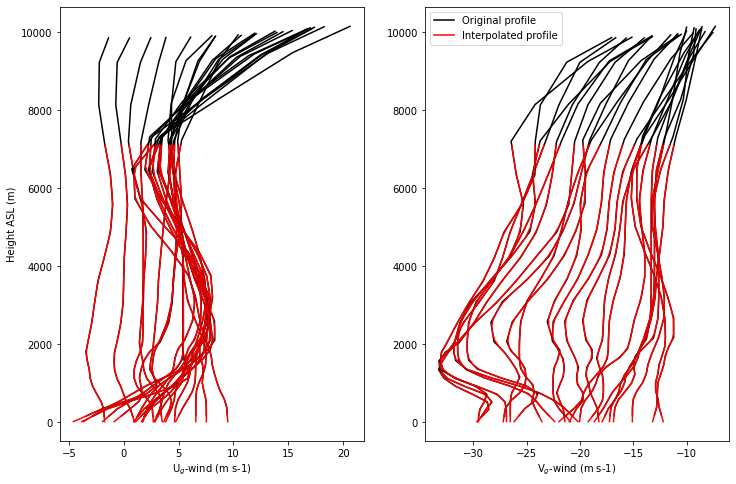

In [18]:
zplt1 = 0
zplt2 = nhrs-3
zplt2b = 50

if do_geo == True:
    plt.figure()
    plt.figure(figsize=(12,8))

    var_plt1 = ugeo
    var_plt2 = ugeoi
    plt.subplot(121)
    for i in np.arange(nhrs):
        plt.plot(var_plt1[i,zplt1:zplt2],zgeo[i,zplt1:zplt2],c='k')
        plt.plot(var_plt2[i,zplt1:zplt2b],zgeoi[zplt1:zplt2b],c='r')
    plt.xlabel('U$_{g}$-wind (m s-1)')
    plt.ylabel('Height ASL (m)')

    var_plt1 = vgeo
    var_plt2 = vgeoi
    plt.subplot(122)
    for i in np.arange(nhrs):
        if i == 0:
            plt.plot(var_plt1[i,zplt1:zplt2],zgeo[i,zplt1:zplt2],c='k',label='Original profile')
            plt.plot(var_plt2[i,zplt1:zplt2b],zgeoi[zplt1:zplt2b],c='r',label='Interpolated profile')
        else:
            plt.plot(var_plt1[i,zplt1:zplt2],zgeo[i,zplt1:zplt2],c='k')
            plt.plot(var_plt2[i,zplt1:zplt2b],zgeoi[zplt1:zplt2b],c='r')
    plt.xlabel('V$_{g}$-wind (m s-1)')
    plt.legend()
    plt.show()

#### Do the linear interpolation for initial forcing profiles

In [19]:
f = interpolate.interp1d(hgt_t0, pres_t0)
pres_t0i = f(zgeoi)
f = interpolate.interp1d(hgt_t0, uwnd_t0)
uwnd_t0i = f(zgeoi)
f = interpolate.interp1d(hgt_t0, vwnd_t0)
vwnd_t0i = f(zgeoi)
f = interpolate.interp1d(hgt_t0, wwnd_t0)
wwnd_t0i = f(zgeoi)
f = interpolate.interp1d(hgt_t0, temp_t0)
temp_t0i = f(zgeoi)
f = interpolate.interp1d(hgt_t0, theta_t0)
theta_t0i = f(zgeoi)
f = interpolate.interp1d(hgt_t0, qv_t0)
qv_t0i = f(zgeoi)
f = interpolate.interp1d(hgt_t0, o3_t0i)
o3_t0i = f(zgeoi)

#### Do the linear interpolation for nudging forcing profiles

In [20]:
unudgei = np.empty([nhrs,len(pres_t0)-1])
vnudgei = np.empty([nhrs,len(pres_t0)-1])
do_t_qv_w = True # temp flag for advection checks
if do_t_qv_w == True:
    tnudgei = np.empty([nhrs,len(pres_t0)-1])
    qvnudgei = np.empty([nhrs,len(pres_t0)-1])
    wnudgei = np.empty([nhrs,len(pres_t0)-1])
count = 0
for i in np.arange(nhrs):
    f = interpolate.interp1d(hgt[t0+i,z1:], uwnd[t0+i,z1:])
    unudgei[count,:] = f(zgeoi)
    f = interpolate.interp1d(hgt[t0+i,z1:], vwnd[t0+i,z1:])
    vnudgei[count,:] = f(zgeoi)
    
    if do_t_qv_w == True:
        f = interpolate.interp1d(hgt[t0+i,z1:], theta[t0+i,z1:])
        tnudgei[count,:] = f(zgeoi)
        
        f = interpolate.interp1d(hgt[t0+i,z1:], qv[t0+i,z1:])
        qvnudgei[count,:] = f(zgeoi)
        
        f = interpolate.interp1d(hgt[t0+i,z1:], wwnd[t0+i,z1:])
        wnudgei[count,:] = f(zgeoi)
    
    count+=1

#### Compare original and interpolated profiles of time-varying nudging wind as example to show efficacy of method

<Figure size 432x288 with 0 Axes>

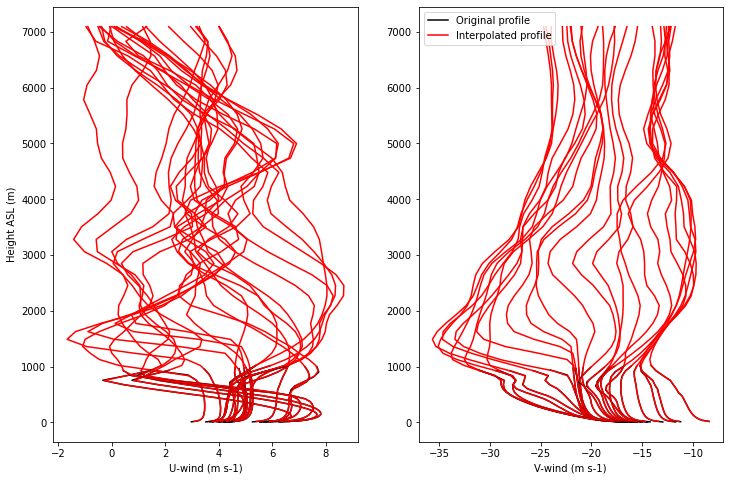

In [21]:
zplt1 = 0
zplt2 = nhrs-3
zplt2b = 50

if do_geo == True:
    plt.figure()
    plt.figure(figsize=(12,8))

    var_plt1 = uwnd
    var_plt2 = unudgei
    plt.subplot(121)
    for i in np.arange(nhrs):
        plt.plot(var_plt1[t0+i,zplt1:zplt2],hgt[t0+i,zplt1:zplt2],c='k')
        plt.plot(var_plt2[i,zplt1:zplt2b],zgeoi[zplt1:zplt2b],c='r')
    plt.xlabel('U-wind (m s-1)')
    plt.ylabel('Height ASL (m)')

    var_plt1 = vwnd
    var_plt2 = vnudgei
    plt.subplot(122)
    for i in np.arange(nhrs):
        if i == 0:
            plt.plot(var_plt1[t0+i,zplt1:zplt2],hgt[t0+i,zplt1:zplt2],c='k',label='Original profile')
            plt.plot(var_plt2[i,zplt1:zplt2b],zgeoi[zplt1:zplt2b],c='r',label='Interpolated profile')
        else:
            plt.plot(var_plt1[t0+i,zplt1:zplt2],hgt[t0+i,zplt1:zplt2],c='k')
            plt.plot(var_plt2[i,zplt1:zplt2b],zgeoi[zplt1:zplt2b],c='r')
    plt.xlabel('V-wind (m s-1)')
    plt.legend()
    plt.show()

#### Compare original and interpolated intial profiles as example to show efficacy of method

<Figure size 432x288 with 0 Axes>

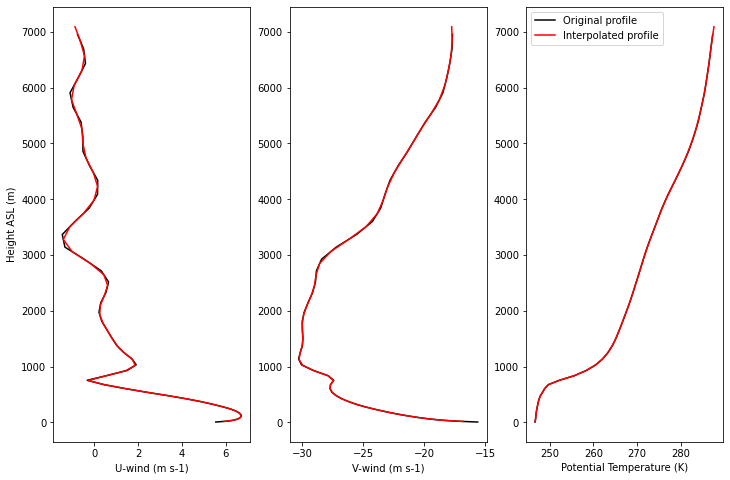

In [22]:
zplt1 = 0
zplt2 = 50

plt.figure()
plt.figure(figsize=(12,8))

var_plt1 = uwnd_t0
var_plt2 = uwnd_t0i
plt.subplot(131)
plt.plot(var_plt1[zplt1:zplt2],hgt_t0[zplt1:zplt2],c='k')
plt.plot(var_plt2[zplt1:zplt2],zgeoi[zplt1:zplt2],c='r')
plt.xlabel('U-wind (m s-1)')
plt.ylabel('Height ASL (m)')

var_plt1 = vwnd_t0
var_plt2 = vwnd_t0i
plt.subplot(132)
plt.plot(var_plt1[zplt1:zplt2],hgt_t0[zplt1:zplt2],c='k')
plt.plot(var_plt2[zplt1:zplt2],zgeoi[zplt1:zplt2],c='r')
plt.xlabel('V-wind (m s-1)')
        
var_plt1 = theta_t0
var_plt2 = theta_t0i
plt.subplot(133)
plt.plot(var_plt1[zplt1:zplt2],hgt_t0[zplt1:zplt2],c='k',label='Original profile')
plt.plot(var_plt2[zplt1:zplt2],zgeoi[zplt1:zplt2],c='r',label='Interpolated profile')
plt.xlabel('Potential Temperature (K)')
plt.legend()
plt.show()

#### Compare original and interpolated nudging profiles as example to show efficacy of method

<Figure size 432x288 with 0 Axes>

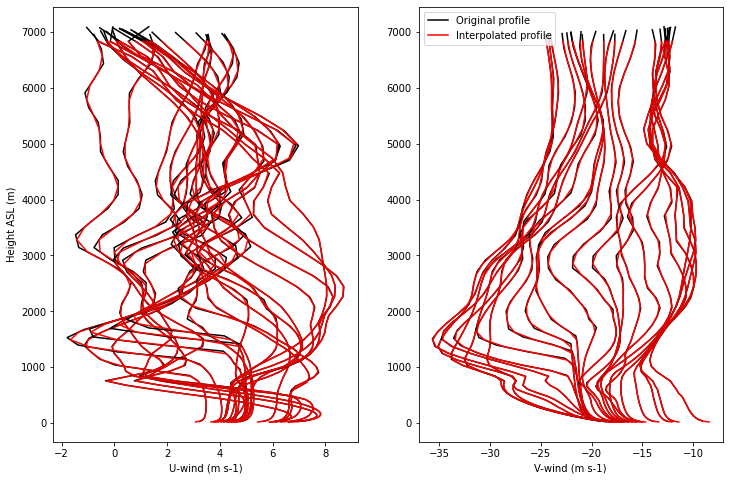

In [23]:
zplt1 = 0
zplt2 = 50

plt.figure()
plt.figure(figsize=(12,8))

var_plt1 = uwnd
var_plt2 = unudgei
plt.subplot(121)
for i in np.arange(nhrs):
    plt.plot(var_plt1[t0+i,zplt1+1:zplt2],hgt[t0+i,zplt1+1:zplt2],c='k')
    plt.plot(var_plt2[i,zplt1:zplt2-1],zgeoi[zplt1:zplt2-1],c='r')
plt.xlabel('U-wind (m s-1)')
plt.ylabel('Height ASL (m)')
        
var_plt1 = vwnd
var_plt2 = vnudgei
plt.subplot(122)
for i in np.arange(nhrs):
    if i == 0:
        plt.plot(var_plt1[t0+i,zplt1+1:zplt2],hgt[t0+i,zplt1+1:zplt2],c='k',label='Original profile')
        plt.plot(var_plt2[i,zplt1:zplt2-1],zgeoi[zplt1:zplt2-1],c='r',label='Interpolated profile')
    else:
        plt.plot(var_plt1[t0+i,zplt1+1:zplt2],hgt[t0+i,zplt1+1:zplt2],c='k')
        plt.plot(var_plt2[i,zplt1:zplt2-1],zgeoi[zplt1:zplt2-1],c='r')
plt.xlabel('V-wind (m s-1)')
plt.legend()
plt.show()

#### Compare original and interpolated nudging profiles as example to show efficacy of method

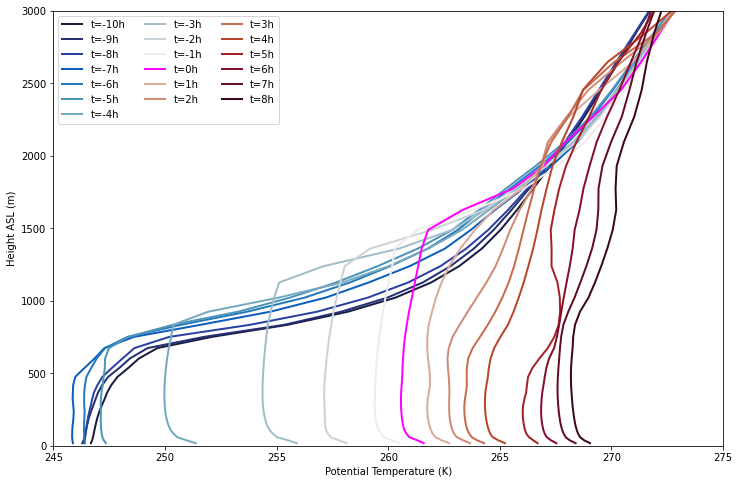

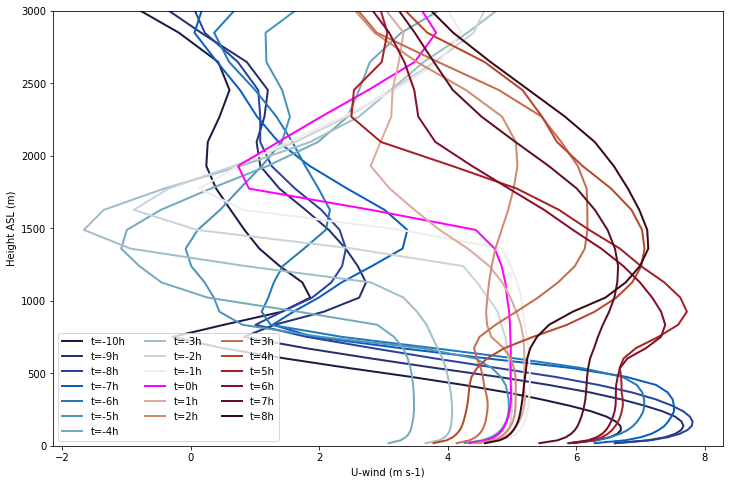

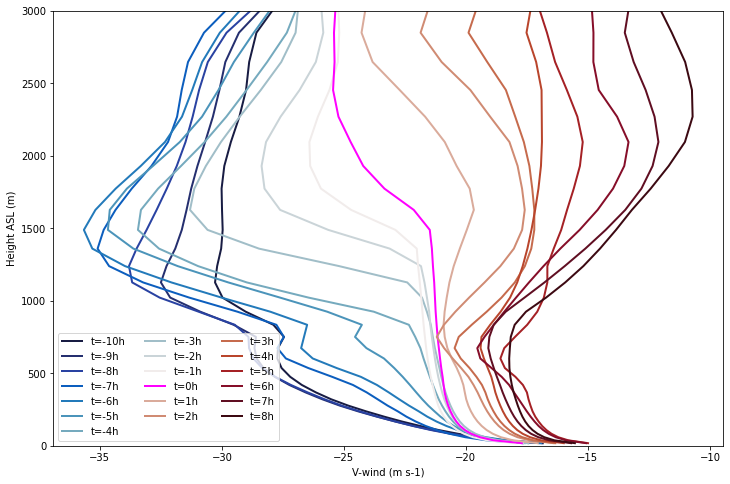

In [24]:
zplt1 = 0
zplt2 = 50

nhrs_plt = 19

import cmocean
colors = cmocean.cm.balance(np.linspace(0,1,nhrs_plt))

lab = np.arange(19)

print_figs = True

for j in np.arange(3):
    plt.figure(figsize=(12,8))
    if j == 0:
        var_plt1 = tnudgei
    elif j == 1:
        var_plt1 = unudgei
    elif j == 2:
        var_plt1 = vnudgei
    for i in np.arange(nhrs_plt):
        if i == 10:
            plt.plot(var_plt1[i,zplt1:zplt2-1],zgeoi[zplt1:zplt2-1],lw=2.,c='magenta',label='t='+str(lab[i]-10)+'h')
        else:
            plt.plot(var_plt1[i,zplt1:zplt2-1],zgeoi[zplt1:zplt2-1],lw=2.,c=colors[i],label='t='+str(lab[i]-10)+'h')
    if j == 0:
        plt.xlabel('Potential Temperature (K)')
    elif j == 1:
        plt.xlabel('U-wind (m s-1)')
    elif j == 2:
        plt.xlabel('V-wind (m s-1)')
    plt.ylabel('Height ASL (m)')
    if j == 0:
        plt.xlim(245,275)
    plt.ylim(0,3000)
    plt.legend(ncol=3)
    
    if print_figs == True:
        if j == 0:
            plt.savefig('ptemp_time_height.png',dpi=300)
        elif j == 1:
            plt.savefig('uwnd_time_height.png',dpi=300)
        elif j == 2:
            plt.savefig('vwnd_time_height.png',dpi=300)

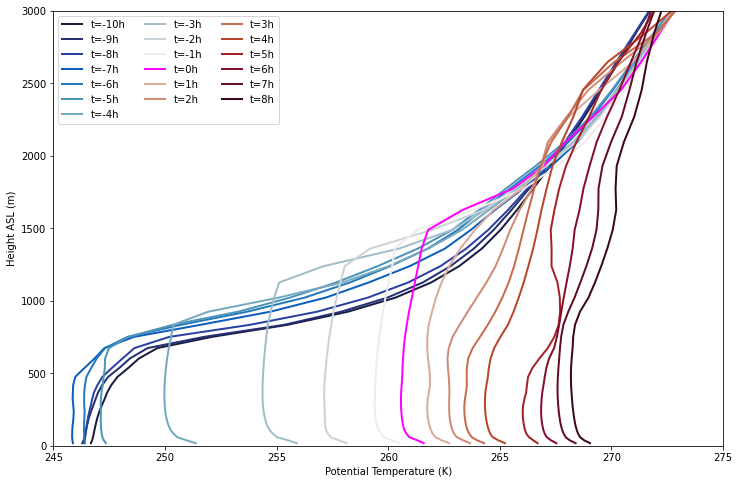

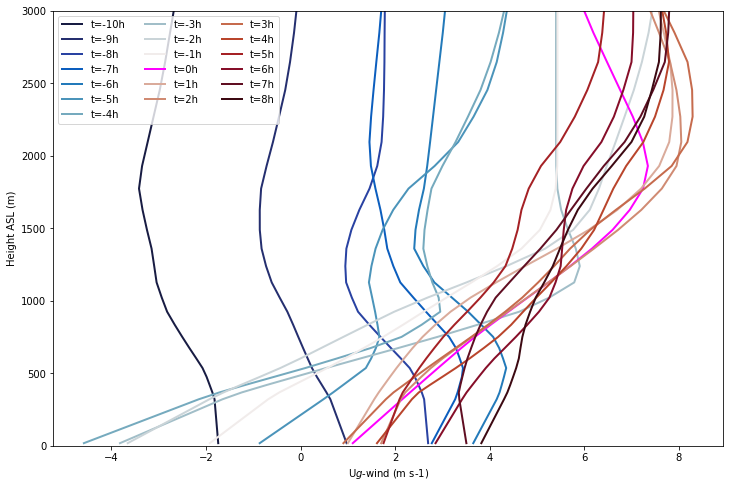

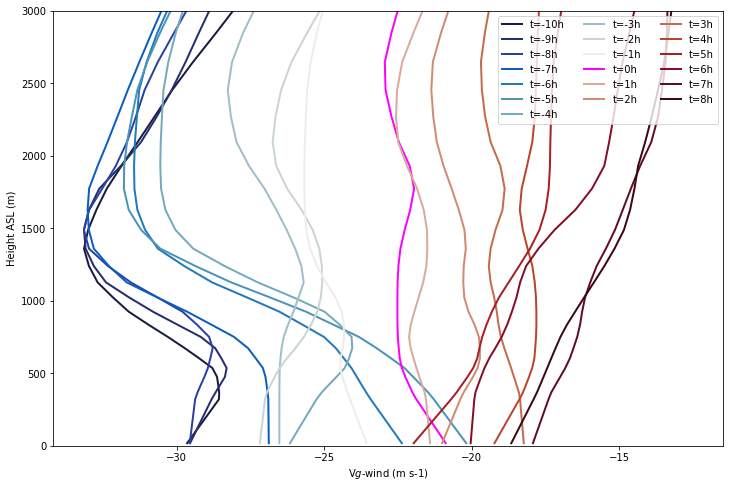

In [25]:
zplt1 = 0
zplt2 = 50

nhrs_plt = 19

import cmocean
colors = cmocean.cm.balance(np.linspace(0,1,nhrs_plt))

lab = np.arange(19)

print_figs = False

for j in np.arange(3):
    plt.figure(figsize=(12,8))
    if j == 0:
        var_plt1 = tnudgei
    elif j == 1:
        var_plt1 = ugeoi
    elif j == 2:
        var_plt1 = vgeoi
    for i in np.arange(nhrs_plt):
        if i == 10:
            plt.plot(var_plt1[i,zplt1:zplt2-1],zgeoi[zplt1:zplt2-1],lw=2.,c='magenta',label='t='+str(lab[i]-10)+'h')
        else:
            plt.plot(var_plt1[i,zplt1:zplt2-1],zgeoi[zplt1:zplt2-1],lw=2.,c=colors[i],label='t='+str(lab[i]-10)+'h')
    if j == 0:
        plt.xlabel('Potential Temperature (K)')
    elif j == 1:
        plt.xlabel('U${g}$-wind (m s-1)')
    elif j == 2:
        plt.xlabel('V${g}$-wind (m s-1)')
    plt.ylabel('Height ASL (m)')
    if j == 0:
        plt.xlim(245,275)
    plt.ylim(0,3000)
    plt.legend(ncol=3)
    
    if print_figs == True:
        if j == 0:
            plt.savefig('ptemp_time_height.png',dpi=300)
        elif j == 1:
            plt.savefig('uwnd_time_height.png',dpi=300)
        elif j == 2:
            plt.savefig('vwnd_time_height.png',dpi=300)

#### Compute ageostrophic winds

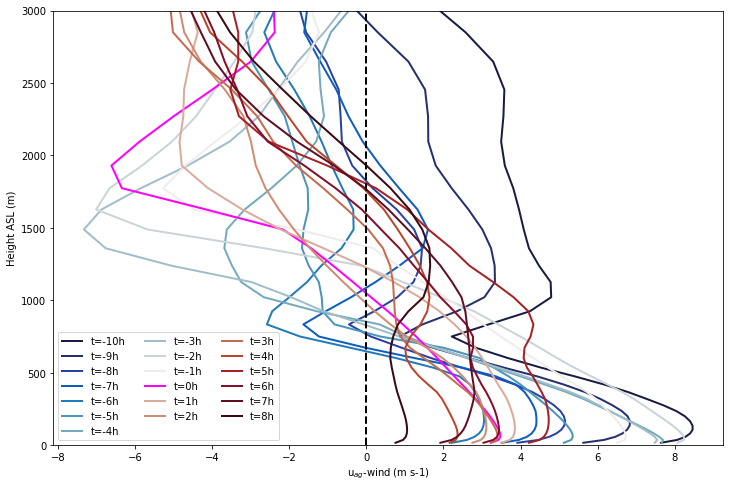

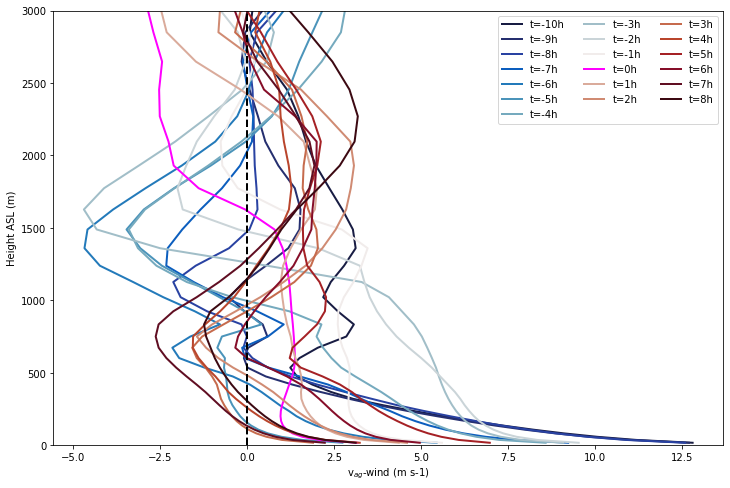

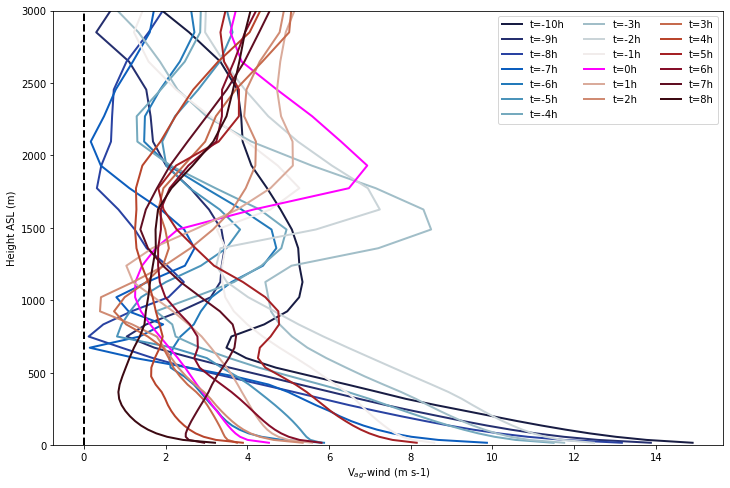

In [26]:
print_figs = False
ymax = 3000

for j in np.arange(3):
    plt.figure(figsize=(12,8))
    if j == 0:
        var_plt1 = unudgei - ugeoi
    elif j == 1:
        var_plt1 = vnudgei - vgeoi
    elif j == 2:
        nudge_wspd = np.sqrt(pow(unudgei,2)+pow(vnudgei,2))
        geo_wspd = np.sqrt(pow(ugeoi,2)+pow(vgeoi,2))
        #var_plt1 = nudge_wspd - geo_wspd
        var_plt1 = np.sqrt(pow(unudgei - ugeoi,2)+pow(vnudgei - vgeoi,2))
    for i in np.arange(nhrs_plt):
        if i == 10:
            plt.plot(var_plt1[i,zplt1:zplt2-1],zgeoi[zplt1:zplt2-1],lw=2.,c='magenta',label='t='+str(lab[i]-10)+'h')
        else:
            plt.plot(var_plt1[i,zplt1:zplt2-1],zgeoi[zplt1:zplt2-1],lw=2.,c=colors[i],label='t='+str(lab[i]-10)+'h')
    plt.plot([0,0],[0,ymax],'k',ls='--',lw=2.)
    if j == 0:
        plt.xlabel('u$_{ag}$-wind (m s-1)')
    elif j == 1:
        plt.xlabel('v$_{ag}$-wind (m s-1)')
    elif j == 2:
        plt.xlabel('V$_{ag}$-wind (m s-1)')
    plt.ylabel('Height ASL (m)')
    plt.ylim(0,ymax)
    plt.legend(ncol=3)
    
    if print_figs == True:
        if j == 0:
            plt.savefig('uagwnd_time_height.png',dpi=300)
        elif j == 1:
            plt.savefig('vagwnd_time_height.png',dpi=300)
        elif j == 2:
            plt.savefig('ageownd_time_height.png',dpi=300)

# DO SFC FORCING

### Calculate sea ice concentration along trajectory

In [27]:
sic_file = netCDF4.Dataset('Svalbard_asi-AMSR2-n10m-20200313_m.nc')
sic = sic_file.variables['z'][:,:]
sic_lat = sic_file.variables['lat'][:]
sic_lon = sic_file.variables['lon'][:]

sic_traj = np.empty(len(les_hh_idx))
for i in np.arange(len(les_hh_idx)):
    abslat = np.abs(sic_lat-les_lat[i])
    abslon = np.abs(sic_lon-les_lon[i])
    jlat = np.argmin(abslat)
    ilon = np.argmin(abslon)
    #print (les_lat[i],les_lon[i])
    #print (jlat,ilon)
    sic_traj[i] = sic[jlat,ilon]
    #print (les_lat_hr[i],les_lon_hr[i],les_hh_hr[les_hh_hr_idx[i]],sic_traj[i])

### Get time series information for sfc forcing

In [28]:
# Interpolate SST
tmp_hh = np.arange(-1*t0_h,19,1) # these are the hours we have SST data from the ERA5 backward trajectory file
f = interpolate.interp1d(tmp_hh, sst[t0:])
sst_interp = f(les_hh[les_hh_idx])
#print (sst_interp)

# Modification for over ice/MIZ
tsk_ice = 247.0
sst_ts = np.empty(len(sic_traj))
for i in np.arange(len(sic_traj)):
    #if t0_h == 10:
    #    if i == 0:
    #        # Insert first position since backward trajectory file does not have t=0 (-28h)
    #        sst_ts[i] = tsk_ice
    #        print ('Computed TSK for hour ' + str(round(5*i/60.,3)) + ': ' + str(round(sst_ts[i],3)))
    if sic_traj[i] > 90.0: # over ice
        sst_ts[i] = tsk_ice
    elif sic_traj[i] > 0.0: # MIZ
        sst_ts[i] = (sic_traj[i]/100.)*tsk_ice + (1.-(sic_traj[i]/100.))*sst_interp[i] # MIZ
    else: # open ocean
        sst_ts[i] = sst_interp[i]
    #if t0_h == 10:
    #    # Do some printing magic
    #    print ('Computed TSK for hour ' + str(round(5/60.+5*i/60.,3)) + ': '
    #           + str(round(sst_ts[i],3)) + ' with SIC = ' + str(sic_traj[i]/100.) +
    #           ' and SST = ' + str(round(sst_interp[i],3)))
    #else:
    print ('Computed TSK for hour ' + str(round(5*i/60.,3)) + ': '
           + str(round(sst_ts[i],3)) + ' with SIC = ' + str(sic_traj[i]/100.) +
           ' and SST = ' + str(round(sst_interp[i],3)))

# Pull hourly SST
sst_ts = sst_ts[::12]

Computed TSK for hour 0.0: 247.0 with SIC = 0.99 and SST = 271.46
Computed TSK for hour 0.083: 247.0 with SIC = 0.99 and SST = 271.46
Computed TSK for hour 0.167: 247.0 with SIC = 0.99 and SST = 271.46
Computed TSK for hour 0.25: 247.0 with SIC = 0.99 and SST = 271.46
Computed TSK for hour 0.333: 247.0 with SIC = 0.99 and SST = 271.46
Computed TSK for hour 0.417: 247.0 with SIC = 0.99 and SST = 271.46
Computed TSK for hour 0.5: 247.0 with SIC = 0.99 and SST = 271.46
Computed TSK for hour 0.583: 247.0 with SIC = 0.99 and SST = 271.46
Computed TSK for hour 0.667: 247.0 with SIC = 0.99 and SST = 271.46
Computed TSK for hour 0.75: 247.0 with SIC = 0.98 and SST = 271.46
Computed TSK for hour 0.833: 247.0 with SIC = 0.98 and SST = 271.46
Computed TSK for hour 0.917: 247.0 with SIC = 0.98 and SST = 271.46
Computed TSK for hour 1.0: 247.0 with SIC = 0.98 and SST = 271.46
Computed TSK for hour 1.083: 247.0 with SIC = 0.98 and SST = 271.46
Computed TSK for hour 1.167: 247.0 with SIC = 0.98 and S

### Create new netcdf file

In [29]:
try: ncfile.close()  # just to be safe, make sure dataset is not already open.
except: pass
ncfile = Dataset('./' + savename,mode='w',format='NETCDF3_CLASSIC') 
#print(ncfile)

### Create dimensions

In [30]:
levs = len(zgeoi)
#levs_o3 = len(pres_t0_o3)
z_grid_levs = len(z_grid)
t0_dim = ncfile.createDimension('t0', 1)     # initial time axis
lat_dim = ncfile.createDimension('lat', 1)     # latitude axis
lon_dim = ncfile.createDimension('lon', 1)     # longitude axis
lev_dim = ncfile.createDimension('lev', levs)      # level axis
#pres_o3_dim = ncfile.createDimension('pres_o3', levs_o3)      # level axis for o3
zw_grid_dim = ncfile.createDimension('zw_grid', z_grid_levs)      # zw_grid axis
time_dim = ncfile.createDimension('time', None)    # unlimited axis (can be appended to)
#for dim in ncfile.dimensions.items():
#    print(dim)

### Create global attributes

In [31]:
ncfile.title='Forcing and initial conditions for 13 March 2020 COMBLE intercomparison case'
ncfile.reference='https://comble-intercomparison.readthedocs.io/en/latest/'
ncfile.authors='Timothy W. Juliano (NCAR/RAL, tjuliano@ucar.edu); Florian Tornow (NASA/GISS, ft2544@columbia.edu); Ann M. Fridlind (NASA/GISS, ann.fridlind@nasa.gov)'
ncfile.version='Created on 2023-06-01'
ncfile.format_version='DEPHY SCM format version 2.0'
ncfile.script='create_comble_forcing_v2.0.ipynb'
ncfile.startDate=start_time
ncfile.endDate='2020-03-13 18:00:00'
ncfile.force_geo=1
ncfile.surfaceType='ocean'
ncfile.surfaceForcing='ts'
ncfile.lat=str(les_lat_mid) + ' deg N'
ncfile.dx='150 m'
ncfile.dy='150 m'
ncfile.dz='see zw_grid variable'
ncfile.nx='648'
ncfile.ny='648'
ncfile.nz='160'

### Create variables

#### Dimensions

In [32]:
t0_time = ncfile.createVariable('t0', np.float32, ('t0',))
t0_time.units = 'seconds since ' + start_time
t0_time.long_name = 'Initial time'

latitude = ncfile.createVariable('lat', np.float32, ('lat',))
latitude.units = 'degrees_north'
latitude.long_name = 'latitude'

longitude = ncfile.createVariable('lon', np.float32, ('lon',))
longitude.units = 'degrees_east'
longitude.long_name = 'longitude'

time = ncfile.createVariable('time', np.float64, ('time',))
time.units = 'seconds since ' + start_time
time.long_name = 'time'

lev = ncfile.createVariable('lev', np.float64, ('lev',))
lev.units = 'm'
lev.long_name = 'altitude'

#pressure_o3 = ncfile.createVariable('pres_o3', np.float64, ('pres_o3',))
#pressure_o3.units = 'Pa'
#pressure_o3.long_name = 'pressure for o3'

#### Initial profiles

In [33]:
pressure = ncfile.createVariable('pressure', np.float64, ('t0','lev','lat','lon',))
pressure.units = 'Pa'
pressure.long_name = 'pressure'

u = ncfile.createVariable('u', np.float64, ('t0','lev','lat','lon',))
u.units = 'm s-1'
u.long_name = 'zonal wind'

v = ncfile.createVariable('v', np.float64, ('t0','lev','lat','lon',))
v.units = 'm s-1'
v.long_name = 'meridional wind'

temperature = ncfile.createVariable('temp', np.float64, ('t0','lev','lat','lon',))
temperature.units = 'K'
temperature.long_name = 'temperature'

ptemperature = ncfile.createVariable('theta', np.float64, ('t0','lev','lat','lon',))
ptemperature.units = 'K'
ptemperature.long_name = 'potential temperature'

qvapor = ncfile.createVariable('qv', np.float64, ('t0','lev','lat','lon',))
qvapor.units = 'kg kg-1'
qvapor.long_name = 'specific humidity'

ozone = ncfile.createVariable('o3', np.float64, ('t0','lev','lat','lon',))
ozone.units = 'kg kg-1'
ozone.long_name = 'ozone mass mixing ratio'

#### Initial sfc conditions

In [34]:
ps = ncfile.createVariable('ps', np.float64, ('t0','lat','lon',))
ps.units = 'Pa'
ps.long_name = 'surface pressure'

thetas = ncfile.createVariable('thetas', np.float64, ('t0','lat','lon',))
thetas.units = 'K'
thetas.long_name = 'surface potential temperature'

#### Time-varying forcing - geostrophic

In [35]:
if do_geo == True:
    ug = ncfile.createVariable('ug', np.float64, ('time','lev',))
    ug.units = 'm s-1'
    ug.long_name = 'geostrophic zonal wind'

    vg = ncfile.createVariable('vg', np.float64, ('time','lev',))
    vg.units = 'm s-1'
    vg.long_name = 'geostrophic meridional wind'

#### Time-varying forcing - nudging

In [36]:
u_nudging = ncfile.createVariable('u_nudging', np.float64, ('time','lev',))
u_nudging.units = 'm s-1'
u_nudging.long_name = 'zonal wind profile for nudging'

v_nudging = ncfile.createVariable('v_nudging', np.float64, ('time','lev',))
v_nudging.units = 'm s-1'
v_nudging.long_name = 'meridional wind profile for nudging'

if do_t_qv_w == True:
    theta_nudging = ncfile.createVariable('theta_nudging', np.float64, ('time','lev',))
    theta_nudging.units = 'K'
    theta_nudging.long_name = 'potential temperature profile for nudging'

    qv_nudging = ncfile.createVariable('qv_nudging', np.float64, ('time','lev',))
    qv_nudging.units = 'kg kg-1'
    qv_nudging.long_name = 'specific humidity profile for nudging'
    
    w_nudging = ncfile.createVariable('w_nudging', np.float64, ('time','lev',))
    w_nudging.units = 'Pa s-1'
    w_nudging.long_name = 'vertical velocity for nudging'

#### Time-varying forcing - surface

In [37]:
ts = ncfile.createVariable('ts', np.float64, ('time',))
ts.units = 'K'
ts.long_name = 'surface temperature'

#### Misc

In [38]:
zw_grid = ncfile.createVariable('zw_grid', np.float64, ('zw_grid',))
zw_grid.units = 'm'
zw_grid.long_name = 'grid altitude at cell faces'

### Write data

In [39]:
t0_time[:] = 0.0
latitude[:] = les_lat_mid
longitude[:] = les_lon_mid
lev[:] = zgeoi
zw_grid[:] = z_grid
pressure[:] = pres_t0i
#pressure_o3[:] = pres_t0_o3
u[:] = uwnd_t0i
v[:] = vwnd_t0i
temperature[:] = temp_t0i
ptemperature[:] = theta_t0i
qvapor[:] = qv_t0i
ozone[:] = o3_t0i

ps[:] = ps_t0
thetas[:] = thetas_t0

if do_geo == True:
    ug[:] = ugeoi
    vg[:] = vgeoi

u_nudging[:] = unudgei
v_nudging[:] = vnudgei

if do_t_qv_w == True:
    theta_nudging[:] = tnudgei
    qv_nudging[:] = qvnudgei
    w_nudging[:] = wnudgei
    
ts[:] = sst_ts

### Add times

In [40]:
dates = []
for i in np.arange(nhrs):
    if nhrs == 19:
        dates.append(dt.datetime(2020,3,13,i))
        print (dt.datetime(2020,3,13,i))
    else:
        if start_hour+i > 23:
            dates.append(dt.datetime(2020,3,13,start_hour+i-24))
            print (dt.datetime(2020,3,13,start_hour+i-24))
        else:
            dates.append(dt.datetime(2020,3,12,start_hour+i))
            print (dt.datetime(2020,3,12,start_hour+i))
times = date2num(dates, time.units)
time[:] = times

2020-03-12 19:00:00
2020-03-12 20:00:00
2020-03-12 21:00:00
2020-03-12 22:00:00
2020-03-12 23:00:00
2020-03-13 00:00:00
2020-03-13 01:00:00
2020-03-13 02:00:00
2020-03-13 03:00:00
2020-03-13 04:00:00
2020-03-13 05:00:00
2020-03-13 06:00:00
2020-03-13 07:00:00
2020-03-13 08:00:00
2020-03-13 09:00:00
2020-03-13 10:00:00
2020-03-13 11:00:00
2020-03-13 12:00:00
2020-03-13 13:00:00
2020-03-13 14:00:00
2020-03-13 15:00:00
2020-03-13 16:00:00
2020-03-13 17:00:00
2020-03-13 18:00:00


### Close the file

In [41]:
# first print the Dataset object to see what we've got
print(ncfile)
# close the Dataset.
ncfile.close(); print('Dataset is closed!')

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    title: Forcing and initial conditions for 13 March 2020 COMBLE intercomparison case
    reference: https://comble-intercomparison.readthedocs.io/en/latest/
    authors: Timothy W. Juliano (NCAR/RAL, tjuliano@ucar.edu); Florian Tornow (NASA/GISS, ft2544@columbia.edu); Ann M. Fridlind (NASA/GISS, ann.fridlind@nasa.gov)
    version: Created on 2023-06-01
    format_version: DEPHY SCM format version 2.0
    script: create_comble_forcing_v2.0.ipynb
    startDate: 2020-03-12 19:00:00
    endDate: 2020-03-13 18:00:00
    force_geo: 1
    surfaceType: ocean
    surfaceForcing: ts
    lat: 75.6 deg N
    dx: 150 m
    dy: 150 m
    dz: see zw_grid variable
    nx: 648
    ny: 648
    nz: 160
    dimensions(sizes): t0(1), lat(1), lon(1), lev(136), zw_grid(160), time(24)
    variables(dimensions): float32 t0(t0), float32 lat(lat), float32 lon(lon), float64 time(time), float64 lev(lev), float64 pre